### 0. Задание

Предположим в ряде городов в определенный период проведен тест:
-	В тестовых городах на веб-сайте пиццы располагаются по популярности
-	Во всех остальных по увеличению цены на пиццу
Вопросы:
1.	На какие метрики мог повлиять тест?
2.	Сделайте визуальный анализ датасета. Как ведут себя метрики в динамике? Какие распределения в данных?
3.	Как можно оценить эффект от теста? Если знаете несколько способов, реализуйте один, а другие опишите письменно. 
4.	Порассуждайте письменно, какие метрики можно было бы еще оценить, если бы вам были доступны все данные компании. 

Тестовый период: 7 апреля - 19 мая
Тестовые города: Пенза, Уфа, Курск, Нижний Тагил, Новокуйбышевск, Орск

Описание датасета:
-	Date : дата
-	CityName : город
-	OrderSource : источник заказа - mp: мобильное приложение, web: веб-сайт, other - другое
-	Category: категория
-	rto: выручка после скидок
-	rto_do: выручка до скидок
-	cost: затраты на себестоимость
-	tickets: кол-во заказов
-	qty - кол-во продуктов
-	clients_qty - уникальное кол-во клиентов
-	avg_time -  среднее время сессии (только по тем, кто оформил заказ)
-	avg_price - средняя цена

### 1. Подготовка данных к работе

In [707]:
# импортируем нужные библиотеки

import pandas as pd
import seaborn as sns
import numpy as np
import datetime as DT
import time
import matplotlib.pyplot as plt

In [708]:
# выгружаем данные

df_origin = pd.read_csv("../Downloads/оценка_категорий.csv")

# Приводим дату к нужному формату

df_origin['Date'] = pd.to_datetime(df_origin['Date'])
df_origin['Date'] = df_origin['Date'].dt.date
df_origin['Date'] = pd.to_datetime(df_origin['Date'])

In [709]:
# Оставляем только нужные разрезы данных

df = df_origin[['Date', 'CityName', 'Category', 'rto','rto_do','cost', 'tickets', 'qty', 'clients_qty', 'avg_time']] \
        .query('Category == "пицца"') \
        .groupby(['Date', 'CityName', 'Category']) \
        .agg({'rto': 'sum', 'rto_do': 'sum', 'cost': 'sum', 'tickets': 'sum', 'qty': 'sum', 'clients_qty': 'sum', 'avg_time': 'mean'}) \
        .sort_values(['Date','rto'], ascending=False) \
        .reset_index()

# Считаем средневзвешенную цену
df['avg_price'] = df['rto'] / df['qty']

# Добавляем метрику среднего чека. Выручка / кол-во заказов
df['avg_check'] = df['rto'] / df['tickets']

df.head()

,Date,CityName,Category,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price,avg_check
0,2022-06-30,Москва,пицца,7923425.100,8667211.20,1875403.490,8667.0,13518.0,9670.0,26.370115,586.138859,914.206196
1,2022-06-30,Санкт-Петербург,пицца,4205321.400,4801755.24,1105300.350,4690.0,8437.0,6075.0,20.751011,498.437999,896.657015
2,2022-06-30,Самара,пицца,1441362.470,1642698.29,340280.031,1337.0,2931.0,2171.0,24.739395,491.764746,1078.057195
3,2022-06-30,Челябинск,пицца,1296803.270,1419035.00,312826.203,1249.0,2538.0,1993.0,28.500620,510.954795,1038.273235
4,2022-06-30,Краснодар,пицца,1217085.964,1334406.08,275495.497,1176.0,2203.0,1688.0,25.942959,552.467528,1034.937044


In [710]:
# Выбираем города для контрольной группы, похожие по характеристикам на тестовую.
# В качестве метрики, по которой будем отбирать города, используем средний чек

list_of_test_cities = ['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']

df_control = df[['Date', 'CityName', 'rto', 'tickets']] \
        .query('Date >=  "2022-02-23" and Date <  "2022-04-07"')
df_control = df_control[['CityName', 'rto', 'tickets']] \
        .groupby(['CityName']) \
        .agg({'rto': 'sum', 'tickets': 'sum'}) \
        .reset_index()
df_control['avg_check'] = df_control['rto'] / df['tickets']
df_control = df_control[['CityName', 'avg_check']] \
        .sort_values(['avg_check'], ascending=False) \
        .reset_index()
df_control = df_control[['CityName', 'avg_check']]

# Получаеам индексы нужных городов
df_control_index = df_control.loc[df_control['CityName'].isin(list_of_test_cities)].reset_index()
df_control_index = df_control_index['index'].to_list()
df_control_index_plus = [x+1 for x in df_control_index]
df_control_index_minus = [x-1 for x in df_control_index]
df_control_index = df_control_index_minus + df_control_index_plus

# Получаем список из нужных городов, близких по значению среднего чека к тестовым городам
df_control['index'] = df_control.index
control_cities_list = df_control.loc[df_control['index'].isin(df_control_index)].reset_index()
control_cities_list = control_cities_list['CityName'].to_list()
control_cities_list

['Краснодар',
 'Сыктывкар',
 'Череповец',
 'Ставрополь',
 'Серпухов',
 'Ханты-Мансийск',
 'Магнитогорск',
 'Новочеркасск',
 'Дмитров',
 'Коммунарка',
 'Сергиев Посад']

In [711]:
# Создаем отдельную колонку, где будет прописано, к какой группе относится город:
# тестовой (участвовал в тесте) или контрольной

def test_or_control (row):
    if row['CityName'] in list_of_test_cities :
      return 'test'
    
    elif row['CityName'] in control_cities_list :
      return 'control'

    return 'other'

df['test_city'] = df.apply (lambda row: test_or_control(row), axis=1)
df = df.query('test_city == "test" or test_city == "control"').sort_values(['Date'], ascending=True)

In [712]:
# Создаем отдельную колонку, где будет прописано, к какому периоду относится дата (до или во время теста)
# Тестовый период: 7 апреля - 19 мая
# Период до теста аналогичной длины (43 дня): 23 февраля - 6 апреля

df = df.query('Date >=  "2022-02-23" and Date <  "2022-05-19"')

s = "2022-04-07"
s = pd.to_datetime(s, format='%Y-%m-%d')

def test_or_control_date(row):
    if row['Date'] < s:
       return 'control'
    
    elif row['Date'] >= s:
      return 'test'

    return 'other'

df['test_date'] = df.apply (lambda row: test_or_control_date(row), axis=1)
df.head()

,Date,CityName,Category,rto,rto_do,cost,tickets,qty,clients_qty,avg_time,avg_price,avg_check,test_city,test_date
33810,2022-02-23,Череповец,пицца,553945.46,588755.47,135467.301,413.0,1003.0,765.0,24.756214,552.288594,1341.272300,control,control
33799,2022-02-23,Ставрополь,пицца,659180.62,728981.64,173854.412,635.0,1356.0,925.0,28.928058,486.121401,1038.079717,control,control
33797,2022-02-23,Пенза,пицца,711017.09,784091.78,186706.412,574.0,1446.0,1117.0,29.095764,491.713064,1238.705732,test,control
33762,2022-02-23,Краснодар,пицца,2301472.89,2437005.15,498362.650,1789.0,4106.0,2690.0,24.226617,560.514586,1286.457736,control,control
33767,2022-02-23,Сыктывкар,пицца,1615330.75,1793502.37,395667.362,1052.0,3336.0,2400.0,32.755768,484.211856,1535.485504,control,control


### 1. На какие метрики мог повлиять тест?

В ряде городов в определенный период проведен тест:
- В тестовых городах на веб-сайте пиццы располагаются по популярности
- Во всех остальных по увеличению цены на пиццу

В первую очередь тест мог повлиять на следующие метрики:

• Выручка и ее составляющие:
- Выручка (rto, rto_do). В контрольной группе пиццы располагаются по увеличению цены. Можно предположить, что клиенты останавливают свой выбор на пиццах из верхней части меню и чем ближе пицца к концу меню, тем реже до нее доскроливают. Соответственно, в тестовой группе выручка должна быть другой так как у нее пиццы располагаются в меню по полярности.
- qty - кол-во продуктов
- avg_price - средняя цена
- кол-во заказов (tickets)
- средний чек (avg_check). Рассчетный показатель. Считается как Выручка / кол-во заказов.

• Дополнительные метрики:
- avg_time -  среднее время сессии (только по тем, кто оформил заказ). Если тестовая версия удобнее, пользователь может тратить меньше времени на заказ. Или наоборот.

### 2. Визуальный анализ датасета
Как ведут себя метрики в динамике? Какие распределения в данных?

<Figure size 842.4x595.44 with 0 Axes>

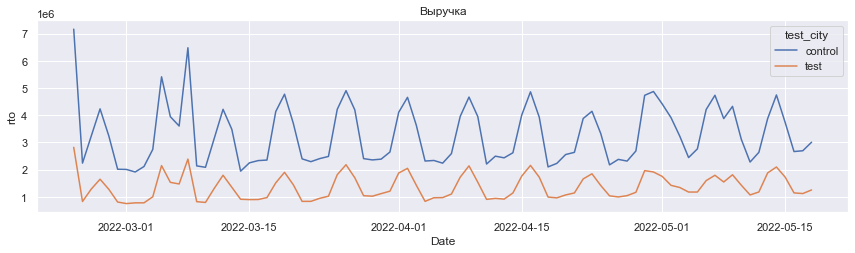

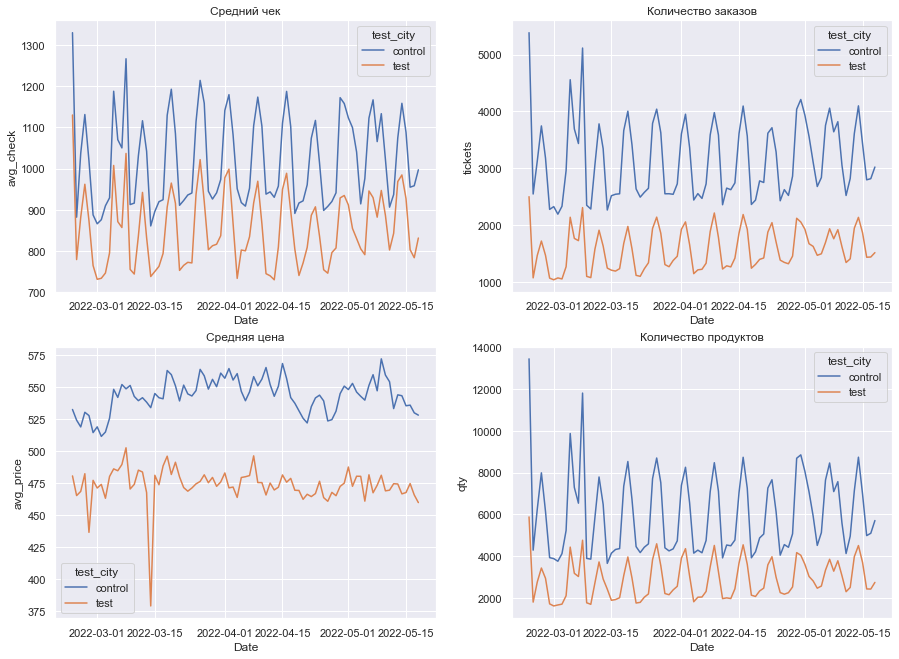

In [731]:
df_vis = df[['Date', 'rto', 'qty', 'tickets', 'test_city', 'test_date']] \
        .groupby(['Date','test_city', 'test_date'], as_index=False) \
        .agg({'rto': 'sum', 'qty': 'sum', 'tickets': 'sum'})
df_vis['avg_price'] = df_vis['rto'] / df_vis['qty']
df_vis['avg_check'] = df_vis['rto'] / df_vis['tickets']

plt.suptitle('Визуальный анализ метрик')
plt.figure(figsize=(32,12))

plt.subplot(3, 2, 1)
sns.lineplot(data=df_vis, x="Date", y="rto", hue='test_city')
plt.title('Выручка')

plt.figure(figsize=(15,17))
plt.subplot(3, 2, 3)
sns.lineplot(data=df_vis, x="Date", y="avg_check", hue='test_city')
plt.title('Средний чек')

plt.subplot(3, 2, 4)
sns.lineplot(data=df_vis, x="Date", y="tickets", hue='test_city')
plt.title('Количество заказов')


plt.subplot(3, 2, 5)
sns.lineplot(data=df_vis, x="Date", y="avg_price", hue='test_city')
plt.title('Средняя цена')

plt.subplot(3, 2, 6)
sns.lineplot(data=df_vis, x="Date", y="qty", hue='test_city')
plt.title('Количество продуктов')

plt.show()

Визуальный анализ датасета показал нам, что метрики в тестовой и контрольной группе в период до теста (начавшегося 7 апреля) и после вели себя примерно одинаково. На графиках отклонений не видно. Посмотрим на распределение данных.

Стоит также отметить, что остальные метрики, кроме среднего чека, по которому мы отбирали города в контрольную группу, сильно отличаются у тестовой и контрольной группы. Это говорит о том, что наша система сплитования некорректно разбила датасет на группы, показатели в них различаются. То есть группы отличались друг от друга и до того,  как мы выкатили на них новую функциональность.

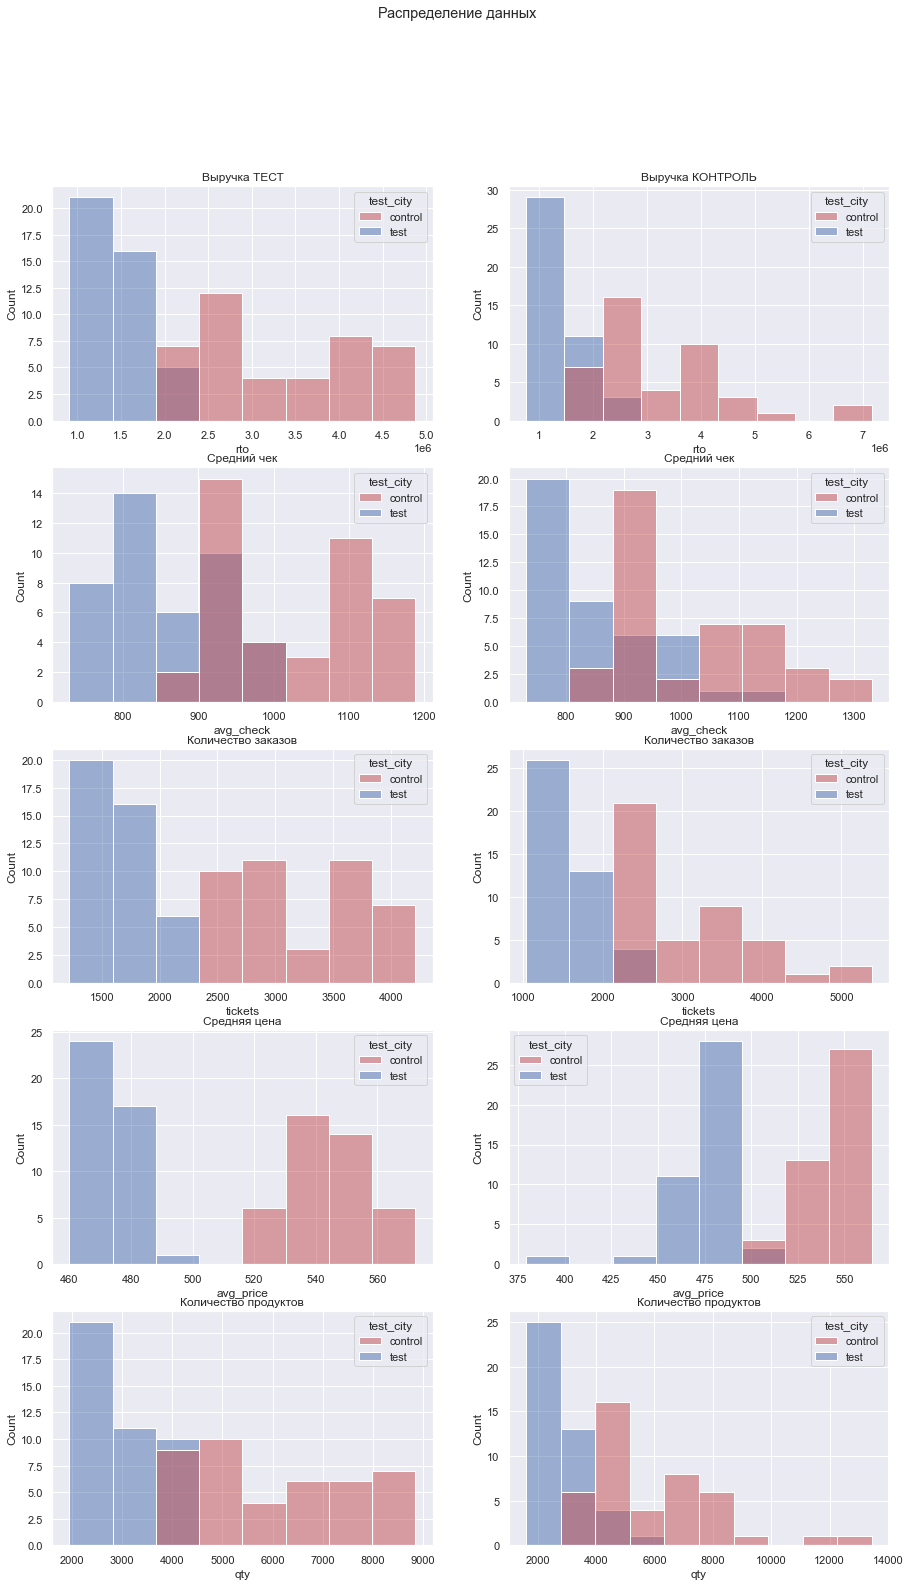

In [732]:
df_vis_test = df_vis.query('test_date == "test"')
df_vis_control = df_vis.query('test_date == "control"')

plt.figure(figsize=(15,25))
plt.suptitle('Распределение данных')

plt.subplot(5, 2, 1)
sns.histplot(data = df_vis_test, x='rto', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Выручка ТЕСТ')

plt.subplot(5, 2, 2)
sns.histplot(data = df_vis_control, x='rto', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Выручка КОНТРОЛЬ')

plt.subplot(5, 2, 3)
sns.histplot(data = df_vis_test, x='avg_check', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Средний чек')

plt.subplot(5, 2, 4)
sns.histplot(data = df_vis_control, x='avg_check', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Средний чек')

plt.subplot(5, 2, 5)
sns.histplot(data = df_vis_test, x='tickets', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Количество заказов')

plt.subplot(5, 2, 6)
sns.histplot(data = df_vis_control, x='tickets', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Количество заказов')

plt.subplot(5, 2, 7)
sns.histplot(data = df_vis_test, x='avg_price', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Средняя цена')

plt.subplot(5, 2, 8)
sns.histplot(data = df_vis_control, x='avg_price', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Средняя цена')

plt.subplot(5, 2, 9)
sns.histplot(data = df_vis_test, x='qty', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Количество продуктов')

plt.subplot(5, 2, 10)
sns.histplot(data = df_vis_control, x='qty', hue='test_city', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Количество продуктов')

plt.show()

Анализ распределения также показал, что метрики в контрольной группе были выше, чем в тестовой как до теста, так и во время теста. Поэтому сравнивать тестовые и контрольные группы в таком виде не имеет смысла. Давайте попробуем сравнить тестовую группу до эксперимента и во время, приняв гипотезу, что на наши данные не влияет сезонность и другие внешние и внутренние факторы. А затем порассуждаем, каких данных нам не хватило для проведения полноценного АВ теста.

### 3. Оценка эффекта от теста
Как можно оценить эффект от теста? Если знаете несколько способов, реализуйте один, а другие опишите письменно. 

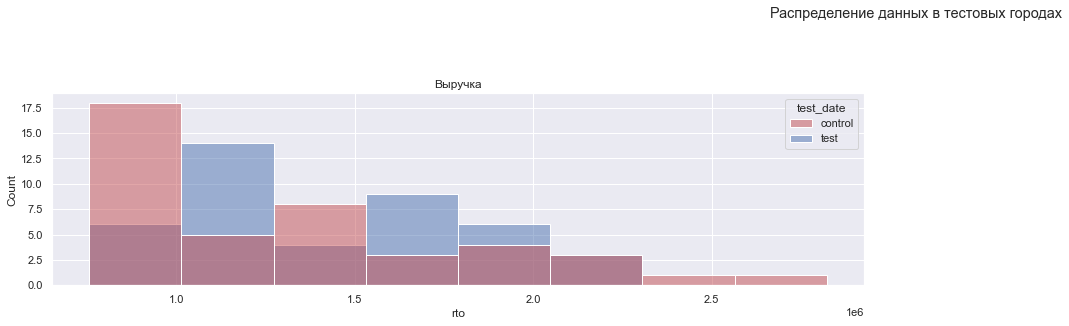

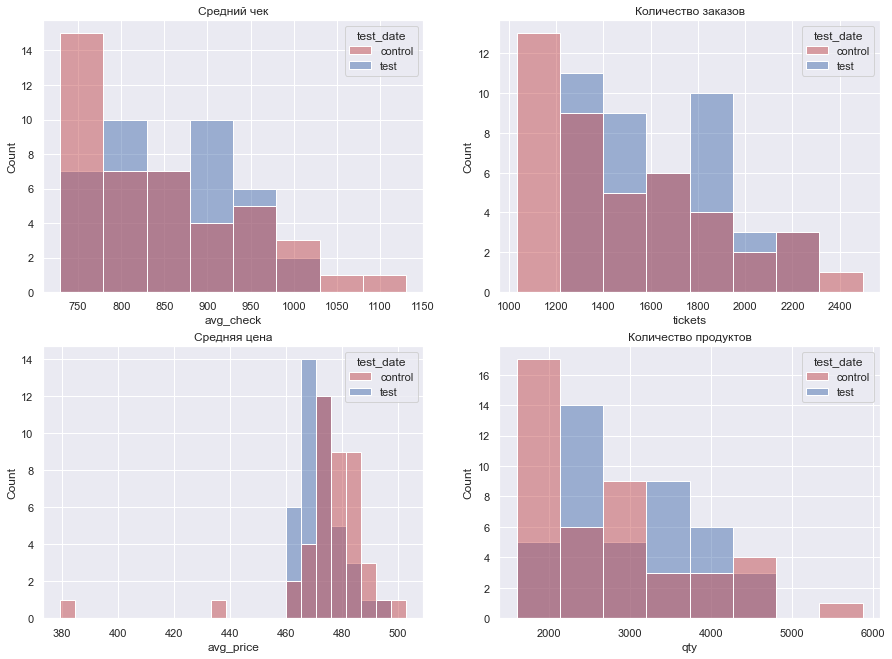

In [733]:
# Посмотрим еще раз на наши данные:

df_vis = df_vis[df_vis.test_city == "test"]

plt.figure(figsize=(32,12))
plt.suptitle('Распределение данных в тестовых городах')

plt.subplot(3, 2, 1)
sns.histplot(data = df_vis, x='rto', hue='test_date', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Выручка')

plt.figure(figsize=(15,17))
plt.subplot(3, 2, 3)
sns.histplot(data = df_vis, x='avg_check', hue='test_date', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Средний чек')

plt.subplot(3, 2, 4)
sns.histplot(data = df_vis, x='tickets', hue='test_date', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Количество заказов')

plt.subplot(3, 2, 5)
sns.histplot(data = df_vis, x='avg_price', hue='test_date', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Средняя цена')

plt.subplot(3, 2, 6)
sns.histplot(data = df_vis, x='qty', hue='test_date', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.title('Количество продуктов')

plt.show()

In [734]:
# Посмотрим и на абсолютные значения метрик

df_vis = df_vis.query('test_city == "test"')
df_vis = df_vis[['test_date','rto', 'tickets', 'qty']] \
        .groupby(['test_date'], as_index=False) \
        .agg({'rto': 'sum', 'tickets': 'sum', 'qty': 'sum'}) \
        .sort_values(['test_date'], ascending=False)
df_vis['avg_price'] = df_vis['rto'] / df_vis['qty']
df_vis['avg_check'] = df_vis['rto'] / df_vis['tickets']

df_vis

,test_date,rto,tickets,qty,avg_price,avg_check
1,test,5.988709e+07,69101.0,126598.0,473.049272,866.660276
0,control,5.610831e+07,64255.0,117762.0,476.455127,873.213114


В городах, где был проведен эксперимент,  на 7% выросла выручка, на 8% количество заказов и количество продуктов, на 1% сократились средняя цена и средний чек.

Делать выводы о том, что это заслуга проведенного эксперимента, тем не менее, мы не можем, так как не знаем, например, сезонности, характерной для этого времени года. Также мы не можем отследить влияние и других факторов - рекламных кампаний, промо и др.

Давайте попробуем все же оценить эффект от эксперимента. Оценивать эффект будем на основе метрики среднего чека. Это довольно стандартная метрика, к тому же она относительная, без привязки к абсолютным значениям аудитории

In [735]:
# Сделаем t-тест Стьюдента по метрике среднего чека

df = df.query('test_city == "test"')

stats.ttest_ind(df[df.test_date == "test"].avg_check,
                df[df.test_date == "control"].avg_check,
                equal_var=False)


Ttest_indResult(statistic=0.42056990304775155, pvalue=0.6742471629991689)

In [736]:
# Сделаем t-тест Стьюдента по метрике выручки
df = df.query('test_city == "test"')

stats.ttest_ind(df[df.test_date == "test"].rto,
                df[df.test_date == "control"].rto,
                equal_var=False)

Ttest_indResult(statistic=1.3359107131605377, pvalue=0.18217918417602516)

P-value в тесте Стьюдента больше 0,05%. Соответственно, нулевая гипотеза о равенстве среднего чека и выручки в группах не отклоняются. Получается, что метрики во время теста и до него в тестовых городах значимо не отличаются.

Пример применения мной  других способов (Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования) можно найти на моем GitHub по ссылке: https://github.com/a-lena-titova/AB-tests

### 4. Рассуждение.
Порассуждайте письменно, какие метрики можно было бы еще оценить, если бы вам были доступны все данные компании.

#### 1. Группы, на которые мы побили датасет, отличались друг от друга и до того, как мы выкатили на тестовую группу новую функциональность. Разбиение на тестовую и контрольную группу было некорректным. 
Сравнивая две группы друг с другом в эксперименте, в идеале мы хотим чтобы разбиение было случайным. А группы отличались бы друг от друга только нашим воздействием в рамках теста (в нашем случае – принципом расположения пиццы в меню). Иными словами, чтобы группы были статистически эквивалентны. Но в нашем датасете идет прямая разбивка по регионам, в тестовую группу попали одни города, а в контрольную - другие. Остальные метрики, кроме среднего чека, по которому мы отбирали города в контрольную группу, сильно отличаются у тестовой и контрольной группы. Это говорит о том, что наша система сплитования некорректно разбила датасет на группы, показатели в них различаются. То есть группы отличались друг от друга и до того, как мы выкатили на них новую функциональность.

#### 2. Выводы невозможно экстраполировать на генеральную совокупность
Проводя эксперимент, мы хотим, чтобы показатели группы отражали показатели в генеральной совокупности. То есть мы хотим провести тест на маленькой группе пользователей, но так, чтобы полученные выводы потом можно было распространить на всех наших пользователей. В случае нашего датасета не понятно, насколько тестовая группа отражает генеральную совокупность. И не факт, что функциональность, которая "зашла" в Пензе, "зайдет" и в Москве.

#### 3. Как это можно исправить?
Отвечая на вопрос, каких данных не хватает для  статистически обоснованного сравнения - я бы сказала, что в первую очередь нам не хватает датасета с данными по клиентам. Подробные данные по клиентам помогли бы нам равномерно распределить аудитории на группы до теста по всем доступным срезам (браузеры, города, источники трафика и т.д.) и получить более статистически достоверные результаты по завершению теста.

Пример применения мной стандартной техники для такого разбиения, хеширования с солью, можно найти на моем GitHub по ссылке: https://github.com/a-lena-titova/AB-tests

Какие еще метрики можно было бы оценить? Тут все зависит от того, какая цель стояла у нашего эксперимента.
- "увеличить деньги" – тогда можно смотреть средний доход на платящего пользователя, средний чек, выручку, стоимость привлечения клиента
- "увеличить вовлеченность" – тогда аудиторные метрики: retention, показатель отказов, число повторных покупок, средняя продолжительность сессии, глубина просмотра страниц